In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_pre=pd.read_csv("preprocessing.csv")
data_pre.head(10)

,Gender,Occupation,Channel_Code,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Age_Group,Vintage_Group
0,0,1,2,1,0.099205,0,0,78,24
1,0,2,0,1,0.054321,0,0,34,24
2,0,3,2,1,0.141660,1,0,56,24
3,1,2,0,1,0.043525,0,0,34,2
4,0,2,0,1,0.083823,0,0,34,24
5,1,3,0,1,0.050659,1,0,56,24
6,1,1,2,2,0.100275,1,1,67,2
7,0,3,2,1,0.041034,1,0,45,2
8,0,3,1,1,0.121331,0,0,45,24
9,0,3,1,0,0.192954,0,0,56,46


## Pre-precessing

In [3]:
from sklearn.utils import resample

data_pre_resampled = resample(data_pre[data_pre['Is_Lead']==0], n_samples=data_pre[data_pre['Is_Lead']==1].shape[0])

data_preproc=pd.concat([data_pre_resampled,data_pre[data_pre['Is_Lead']==1]])

data_preproc['Is_Lead'].value_counts()

1    58288
0    58288
Name: Is_Lead, dtype: int64

In [4]:
#droping target-variable for the pre
X=data_preproc.drop('Is_Lead', axis=1)
Y=data_preproc['Is_Lead']

# Splitting to Training and Test
from sklearn.model_selection import train_test_split

train_x, test_x , train_y, test_y = train_test_split(X, Y, stratify=Y, test_size=0.6)

tr_x, val_x , tr_y, val_y = train_test_split(train_x, train_y, stratify=train_y, test_size=0.5)

train_x.shape, test_x.shape, train_y.shape, test_y.shape, tr_x.shape, val_x.shape , tr_y.shape, val_y.shape

((89522, 8),
 (10142, 8),
 (89522,),
 (10142,),
 (44761, 8),
 (44761, 8),
 (44761,),
 (44761,))

## Training Model and data validation

##### Decission Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

train_acc=[]
val_acc=[]

for depth in range(1,15):
    model=DecisionTreeClassifier(max_depth=depth, random_state=11)
    model.fit(tr_x,tr_y)
    pred_prob=model.predict_proba(tr_x)
    auc_score_tr=roc_auc_score(tr_y, pred_prob[:,1])
    train_acc.append(auc_score_tr)
    pred_prob=model.predict_proba(val_x)
    auc_score_val=roc_auc_score(val_y, pred_prob[:,1])
    val_acc.append(auc_score_val)

In [6]:
df=pd.DataFrame({'depth':range(1,15), 'training_auc_score':train_acc, 'validation_auc_score':val_acc})
df

,depth,training_auc_score,validation_auc_score
0,1,0.703508,0.703610
1,2,0.815506,0.817944
2,3,0.843207,0.843449
3,4,0.855610,0.854942
4,5,0.862235,0.859947
5,6,0.866754,0.862915
6,7,0.871398,0.865424
7,8,0.874830,0.863846
8,9,0.879315,0.860329
9,10,0.884605,0.857001


Text(0, 0.5, 'Tree Depth')

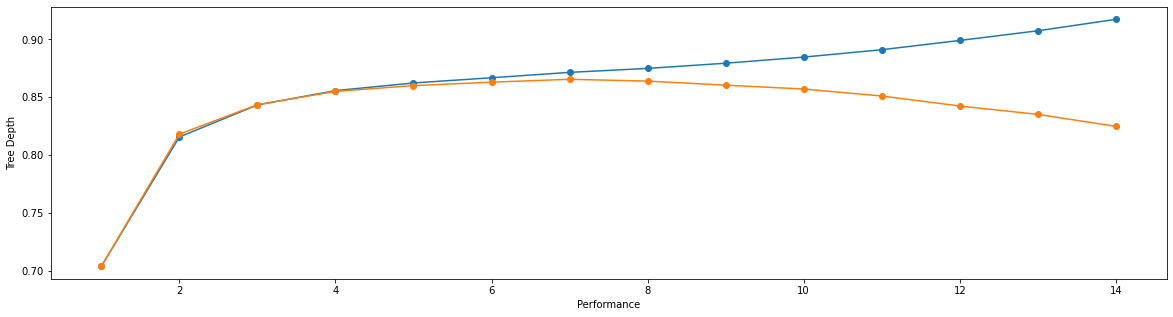

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df['depth'], df['training_auc_score'], marker='o')
plt.plot(df['depth'], df['validation_auc_score'], marker='o')
plt.xlabel('Performance')
plt.ylabel('Tree Depth')

##### We will settle on the max-depth of 6, where validation first shows difference

In [8]:
model=DecisionTreeClassifier(max_depth=6)
model.fit(train_x,train_y)
pred_prob=model.predict_proba(test_x)
auc_score=roc_auc_score(test_y, pred_prob[:,1])
print("Decision Tree = " + str(auc_score))

Decision Tree = 0.8705662961999555


## Test Prediction

In [9]:
test=pd.read_csv("test.csv")
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [10]:
## Age
test=test.assign(Age_Group = test['Age'].apply(lambda x : 23 if (x>=20 and x<30)
                                               else (34 if (x>=30 and x<40)
                                                     else (45 if (x>=40 and x<50)
                                                           else (56 if (x>=50 and x<60)
                                                                 else (67 if (x>=60 and x<70)
                                                                       else (78 if (x>=70 and x<80)
                                                                             else 80)))))))
# Fill Credit_Product
test['Credit_Product']=test['Credit_Product'].fillna('0')

## Vintage
test=test.assign(Vintage_Group = test['Vintage'].apply(lambda x : 2 if (x>=0 and x<24)
                                               else (24 if (x>=24 and x<48)
                                                     else (46 if (x>=48 and x<72)
                                                           else (68 if (x>=72 and x<96)
                                                                 else (81 if (x>=96 and x<120)
                                                                       else 99))))))

test=test.drop(['Age','Vintage'], axis=1)
test['Gender'].replace({'Male':1, 'Female':0}, inplace=True)
test['Occupation'].replace({'Entrepreneur':0, 'Other':1, 'Salaried':2, 'Self_Employed':3}, inplace=True)
test['Channel_Code'].replace({'X1':0, 'X2':1, 'X3':2, 'X4':3}, inplace=True)
test['Is_Active'].replace({'Yes':1, 'No':0}, inplace=True)
test['Credit_Product'].replace({'Yes':0,'No':1,'0':2},inplace=True)
test.head()

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Avg_Account_Balance,Is_Active,Age_Group,Vintage_Group
0,VBENBARO,1,RG254,1,0,0,742366,0,23,24
1,CCMEWNKY,1,RG268,1,1,2,925537,0,45,46
2,VK3KGA9M,1,RG270,2,0,1,215949,0,34,2
3,TT8RPZVC,1,RG272,1,0,1,868070,0,23,24
4,SHQZEYTZ,0,RG270,1,0,1,657087,0,23,2


In [11]:
#Removing ID and region
test_tst=test.drop(['ID','Region_Code'], axis=1)


#scaling Avg_Account_Balance with Standard-Deviation
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
test_tst['Avg_Account_Balance'] = ss.fit_transform(test_tst[['Avg_Account_Balance']])
test_tst.head()

,Gender,Occupation,Channel_Code,Credit_Product,Avg_Account_Balance,Is_Active,Age_Group,Vintage_Group
0,1,1,0,0,0.072805,0,23,24
1,1,1,1,2,0.091333,0,45,46
2,1,2,0,1,0.019558,0,34,2
3,1,1,0,1,0.085520,0,23,24
4,0,1,0,1,0.064179,0,23,2


In [12]:
predicted_val=model.predict(test_tst)
Final=pd.DataFrame({'ID':test['ID'],'Is_Lead':predicted_val})
Final.to_csv('DT-Final-resampled.csv',index=False)